<a href="https://colab.research.google.com/github/kri8tinam/Low-Resource-Deontic-Modality-Classification-in-EU-Legislation/blob/main/Data_Sampling%2C_Similarity_Filtering_and_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
#loading and visualizing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
import torch
import os
import random as rn


#tokenization
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.0 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer, util

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.3 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125925 sha256=96e2d206cad5138292ec7b466ee216778f718109676f83d2e1cf33a017336f45
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

train_data = pd.read_csv('/content/drive/MyDrive/TRAIN.csv', delimiter= ',')
test_data = pd.read_csv('/content/drive/MyDrive/TEST.csv', delimiter= ',')

Mounted at /content/drive


# Synthetic (Train) Data

In [ ]:
syndata = pd.read_csv('/content/drive/MyDrive/syndata.csv', delimiter= ';')
syndata

,text,category
0,It is illegal to drive a car without a valid d...,prohibition
1,It is forbidden to possess or use illegal drugs,prohibition
2,It is not allowed to discriminate against peop...,NaN
3,It is unlawful to commit fraud or other financ...,prohibition
4,It is prohibited to engage in insider trading,prohibition
...,...,...
510,The legislature has the capability to pass law...,power
511,The government has the authority to issue laws...,power
512,The police have the capability to investigate ...,power
513,The legislature has the capacity to alter laws...,power


In [ ]:
syndata['category'].value_counts()

permission     117
prohibition    105
obligation      85
omission        83
power           74
right           47
 omission        1
Name: category, dtype: int64

In [ ]:
syndata.loc[syndata['category'].isna()]

,text,category
2,It is not allowed to discriminate against peop...,NaN
57,It is prohibited to discriminate against someo...,NaN
332,It is unlawful to discriminate against someone...,NaN


In [ ]:
syndata['category'].fillna('prohibition', inplace=True)
syndata['text'][2] = 'It is not allowed to discriminate against people based on their race, gender or religion'
syndata['text'][57] = 'It is prohibited to discriminate against someone based on their race, gender or religion'
syndata['text'][332] = 'It is unlawful to discriminate against someone based on their race, gender or religion'

In [ ]:
print(syndata['category'].value_counts())
syndata

permission     117
prohibition    108
obligation      85
omission        83
power           74
right           47
 omission        1
Name: category, dtype: int64


,text,category
0,It is illegal to drive a car without a valid d...,prohibition
1,It is forbidden to possess or use illegal drugs,prohibition
2,It is not allowed to discriminate against peop...,prohibition
3,It is unlawful to commit fraud or other financ...,prohibition
4,It is prohibited to engage in insider trading,prohibition
...,...,...
510,The legislature has the capability to pass law...,power
511,The government has the authority to issue laws...,power
512,The police have the capability to investigate ...,power
513,The legislature has the capacity to alter laws...,power


In [ ]:
syndata[syndata['category'] == ' omission']

,text,category
477,A person is allowed to not donate to charity.,omission


In [ ]:
syndata['category'][477] = 'omission'

Text(0.5, 1.0, 'Number of provisions')

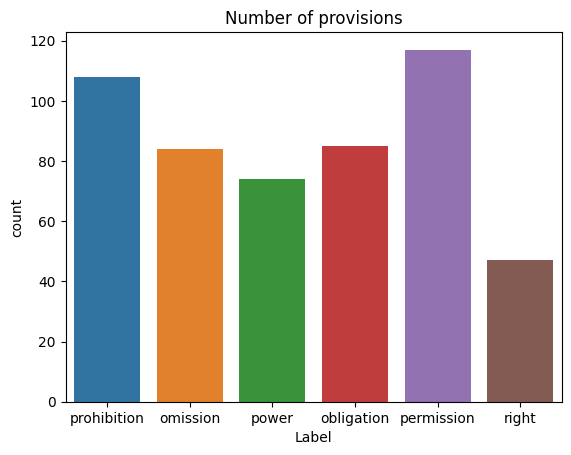

In [ ]:
sns.countplot(x=syndata["category"])
plt.xlabel('Label')
plt.title('Number of provisions')

In [ ]:
train_data = pd.DataFrame(syndata)
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data

,text,category
0,Individual s must pay their taxes on time,obligation
1,EU citizens are allowed to receive travel dedu...,permission
2,Individuals must obtain a permit to carry a fi...,obligation
3,Individuals must obtain a license to practice ...,obligation
4,The police have the power to detain individual...,power
...,...,...
510,Individuals have the right to not be subject t...,permission
511,It is prohibited to discriminate against someo...,prohibition
512,People have the prerogative to challenge the u...,right
513,People have the entitlement to not be subject ...,right


# Synthetic (Test) Data




In [ ]:
test_data= pd.read_excel('/content/drive/MyDrive/test_data.xlsx')
print(test_data['category'].value_counts())
test_data

obligations     71
permission      66
right           60
prohibitions    58
power           54
omission        17
Name: category, dtype: int64


,text,category
0,Organizations must ensure that their product l...,omission
1,Organizations must ensure that their product t...,obligations
2,Organizations must ensure that their product p...,obligations
3,EU citizens can receive freedom of the press i...,permission
4,The Union shall ensure the right to protection...,prohibitions
...,...,...
321,Organizations must ensure that their contracts...,obligations
322,For a period of twenty-nine years from 1 Janua...,right
323,The Union shall ensure the freedom of establis...,prohibitions
324,For a period of thirty years from 1 October 20...,right


Text(0.5, 1.0, 'Number of provisions')

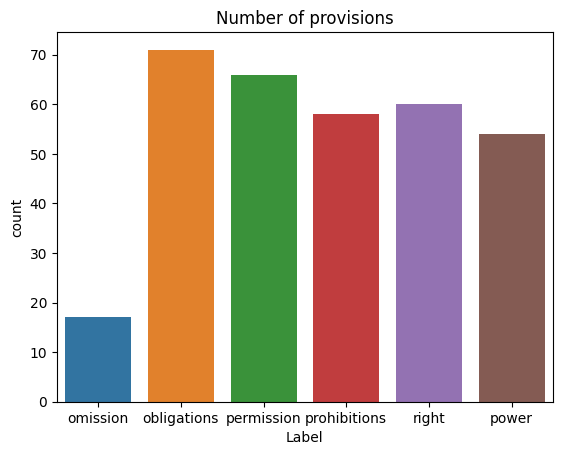

In [ ]:
sns.countplot(x=test_data["category"])
plt.xlabel('Label')
plt.title('Number of provisions')

In [ ]:
test_data = test_data.sample(frac=1).reset_index(drop=True)
test_data


,text,category
0,Organizations must ensure that their product r...,obligations
1,For a period of thirty years from 1 October 20...,right
2,Member States may adopt measures to limit acce...,power
3,For a period of seventeen years from 1 October...,right
4,Organizations must ensure that their product r...,obligations
...,...,...
321,Member States may adopt measures to limit acce...,power
322,Organizations must ensure that their product a...,obligations
323,The Union shall ensure the right to protection...,prohibitions
324,For a period of twenty years from 1 November 2...,power


# Sampling

In [ ]:
def get_balanced_sample(df, label_col, num_samples):

    # Calculate the approximate number of samples per label
    samples_per_label = num_samples // len(df[label_col].unique())

    # Sample approximately the same number of samples per label
    sampled_df = df.groupby(label_col).apply(lambda x: x.sample(n=min(samples_per_label, len(x))))

    # Reset the index of the sampled dataframe
    sampled_df = sampled_df.reset_index(drop=True)

    # Take a random sample of remaining samples to reach the desired total number
    remaining_samples = num_samples - len(sampled_df)
    if remaining_samples > 0:
        remaining_df = df[~df.index.isin(sampled_df.index)].sample(n=remaining_samples, random_state=42)
        sampled_df = pd.concat([sampled_df, remaining_df]).reset_index(drop=True)

    return sampled_df

100 samples

In [ ]:
train100 = get_balanced_sample(train_data, 'category', 100).sample(frac=1).reset_index(drop=True)

In [ ]:
train100['category'].value_counts()

omission       18
prohibition    17
permission     17
obligation     16
power          16
right          16
Name: category, dtype: int64

Text(0.5, 1.0, 'Number of provisions')

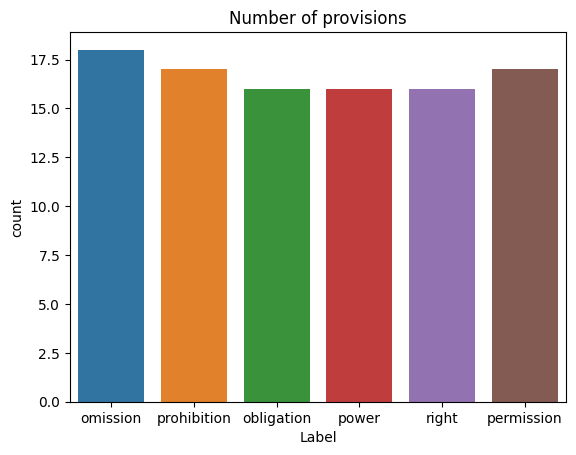

In [ ]:
sns.countplot(x=train100["category"])
plt.xlabel('Label')
plt.title('Number of provisions')

 200 samples

In [ ]:
train200 = get_balanced_sample(train_data, 'category', 200).sample(frac=1).reset_index(drop=True)
train200['category'].value_counts()

prohibition    34
power          34
right          33
permission     33
obligation     33
omission       33
Name: category, dtype: int64

300 samples

In [ ]:
train300 = get_balanced_sample(train_data, 'category', 300).sample(frac=1).reset_index(drop=True)

350 samples

In [ ]:
train350 = get_balanced_sample(train_data, 'category', 350).sample(frac=1).reset_index(drop=True)

400 samples

In [ ]:
train400 = get_balanced_sample(train_data, 'category', 400).sample(frac=1).reset_index(drop=True)

450 samples

In [ ]:
train450 = get_balanced_sample(train_data, 'category', 450).sample(frac=1).reset_index(drop=True)

**Save all of them**
___

In [ ]:
train_data.to_csv('/content/drive/MyDrive/TRAIN.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/TEST.csv', index=False)

# Samples
train100.to_csv('/content/drive/MyDrive/train100.csv', index=False)
train200.to_csv('/content/drive/MyDrive/train200.csv', index=False)
train300.to_csv('/content/drive/MyDrive/train300.csv', index=False)
train350.to_csv('/content/drive/MyDrive/train350.csv', index=False)
train400.to_csv('/content/drive/MyDrive/train400.csv', index=False)
train450.to_csv('/content/drive/MyDrive/train450.csv', index=False)

# Similarity filtering

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def similarity_bert(df, number, model):


    # Encode the text data into BERT embeddings
    embeddings = model.encode(df['text'], convert_to_tensor=True)

    similarity_matrix = util.pytorch_cos_sim(embeddings, embeddings)
    similarity_matrix = pd.DataFrame(similarity_matrix.numpy(), index=df.index, columns=df.index)

    key_value_dict = {}

    # Iterate over columns and rows
    for col_name, col_values in similarity_matrix.iteritems():
      key_value_dict[col_name] = list(col_values[col_values > 0.8].index)

    # Print the resulting dictionary
    print(key_value_dict)

    unique_sent = [key for key, value in key_value_dict.items() if len(value) <= number]
    sim_sent = [key for key, value in key_value_dict.items() if len(value) > number]

    return unique_sent, sim_sent, similarity_matrix


In [ ]:
train_unique1, train_sim1, train_matrix1  = similarity_bert(train_data, 1, model)
print('\n')
print('Entries in TRAIN data that have > 0.8 similarity with only 1 entry (themselves) - Unique entries:',len(list(set(train_unique1))))
print('Entries in TRAIN data that have > 0.8 similarity with more than 1 entry:',len(list(set(train_sim1))))

<ipython-input-4-c66fd13cb947>:15: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, col_values in similarity_matrix.iteritems():


{0: [0, 242], 1: [1, 2, 9, 25, 39, 55, 58, 77, 84, 96, 108, 121, 135, 148, 158, 160, 183, 203, 222, 226, 228, 275, 276, 304, 305, 307, 317, 338, 339, 340, 347, 356, 361, 370, 373, 374, 376, 389, 393, 401, 402, 412, 417, 424, 436, 437, 443, 447, 478, 493, 500, 512], 2: [1, 2, 9, 25, 39, 55, 58, 77, 84, 96, 108, 121, 135, 148, 158, 160, 183, 203, 222, 226, 228, 275, 276, 305, 307, 317, 338, 339, 347, 356, 361, 370, 373, 374, 376, 389, 393, 401, 402, 412, 417, 424, 436, 437, 443, 447, 478, 493, 500, 512], 3: [3], 4: [4], 5: [5, 85, 255], 6: [6, 59, 62, 97, 151, 403, 473, 482, 509, 514], 7: [7, 36, 89, 151, 332, 407], 8: [8, 197], 9: [1, 2, 9, 25, 39, 55, 58, 84, 96, 108, 121, 135, 148, 158, 160, 183, 203, 222, 226, 228, 275, 276, 304, 305, 307, 317, 338, 339, 340, 347, 356, 361, 370, 373, 374, 376, 389, 393, 401, 402, 412, 417, 424, 436, 437, 443, 447, 478, 493, 500, 512], 10: [10], 11: [11], 12: [12, 13, 60, 61, 67, 90, 93, 130, 138, 141, 217, 236, 244, 265, 267, 272, 328, 359, 360, 365,

In [ ]:
train_unique5, train_sim5, train_matrix5  = similarity_bert(train_data, 5, model)
print('\n')
print('Entries in TRAIN data that have > 0.8 similarity with at most 5 entries:',len(list(set(train_unique5))))
print('Entries in TRAIN data that have > 0.8 similarity with more than 5 other entries:',len(list(set(train_sim5))))

<ipython-input-4-c66fd13cb947>:15: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, col_values in similarity_matrix.iteritems():


{0: [0, 242], 1: [1, 2, 9, 25, 39, 55, 58, 77, 84, 96, 108, 121, 135, 148, 158, 160, 183, 203, 222, 226, 228, 275, 276, 304, 305, 307, 317, 338, 339, 340, 347, 356, 361, 370, 373, 374, 376, 389, 393, 401, 402, 412, 417, 424, 436, 437, 443, 447, 478, 493, 500, 512], 2: [1, 2, 9, 25, 39, 55, 58, 77, 84, 96, 108, 121, 135, 148, 158, 160, 183, 203, 222, 226, 228, 275, 276, 305, 307, 317, 338, 339, 347, 356, 361, 370, 373, 374, 376, 389, 393, 401, 402, 412, 417, 424, 436, 437, 443, 447, 478, 493, 500, 512], 3: [3], 4: [4], 5: [5, 85, 255], 6: [6, 59, 62, 97, 151, 403, 473, 482, 509, 514], 7: [7, 36, 89, 151, 332, 407], 8: [8, 197], 9: [1, 2, 9, 25, 39, 55, 58, 84, 96, 108, 121, 135, 148, 158, 160, 183, 203, 222, 226, 228, 275, 276, 304, 305, 307, 317, 338, 339, 340, 347, 356, 361, 370, 373, 374, 376, 389, 393, 401, 402, 412, 417, 424, 436, 437, 443, 447, 478, 493, 500, 512], 10: [10], 11: [11], 12: [12, 13, 60, 61, 67, 90, 93, 130, 138, 141, 217, 236, 244, 265, 267, 272, 328, 359, 360, 365,

In [ ]:
train_matrix1

,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,512,513,514
0,1.000000,0.092082,0.111745,-0.046807,0.014096,0.325290,0.122310,0.194532,0.215885,0.107713,...,0.024238,0.067053,0.106377,0.086408,0.093817,0.051126,0.149659,0.108057,0.123689,0.112595
1,0.092082,1.000000,0.884240,0.083672,0.244225,0.186080,0.058959,0.082939,0.213863,0.882661,...,0.466508,0.508869,0.410776,0.219601,0.064811,0.526779,0.380868,0.906220,0.258787,0.045807
2,0.111745,0.884240,1.000000,0.057460,0.205309,0.203815,0.070209,0.065334,0.209920,0.856288,...,0.463089,0.516085,0.478383,0.098405,0.086328,0.508247,0.276305,0.901007,0.184778,0.056939
3,-0.046807,0.083672,0.057460,1.000000,0.153570,0.045943,0.119821,0.063174,0.280809,0.122829,...,0.052067,-0.024706,0.115248,0.123911,0.137443,0.042464,0.147708,0.057201,0.124707,0.041103
4,0.014096,0.244225,0.205309,0.153570,1.000000,0.214751,0.131070,0.125983,0.243391,0.231731,...,0.488204,0.399585,0.491444,0.376011,0.115340,0.525506,0.294171,0.328984,0.173924,0.128089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,0.051126,0.526779,0.508247,0.042464,0.525506,0.241587,0.146440,0.159895,0.195571,0.489530,...,0.851475,0.764841,0.720579,0.167548,0.153763,1.000000,0.259128,0.632388,0.122147,0.140530
511,0.149659,0.380868,0.276305,0.147708,0.294171,0.201941,0.236842,0.175539,0.434001,0.347011,...,0.176165,0.153043,0.122400,0.387084,0.257622,0.259128,1.000000,0.372224,0.568943,0.166028
512,0.108057,0.906220,0.901007,0.057201,0.328984,0.231542,0.141541,0.157203,0.209651,0.850607,...,0.498700,0.519596,0.462342,0.204829,0.125839,0.632388,0.372224,1.000000,0.241797,0.131648
513,0.123689,0.258787,0.184778,0.124707,0.173924,0.217809,0.111972,0.054166,0.306104,0.330189,...,0.194021,0.154320,0.137710,0.406479,0.166131,0.122147,0.568943,0.241797,1.000000,0.046371


In [ ]:
print(train_data['text'][1],'\n', train_data['text'][119])
print('\n')
print(train_data['text'][2],'\n', train_data['text'][428])
print('\n')
print(train_data['text'][4],'\n', train_data['text'][32])
print('\n')
print(train_data['text'][29],'\n', train_data['text'][352])
print('\n')
print(train_data['text'][32],'\n', train_data['text'][79])

People are given the power to not accept automated processing decisions 
 Individuals are allowed to not request a copy of the data processing data transfer schedule.


Individuals have the capacity to not participate in automated processing decisions 
 EU citizens are allowed to receive financial assistance in other EU countries.


A person has the right to privacy. 
 It is unlawful to discriminate against someone based on their race, gender or religion


The government has the power to levy taxes. 
 Food businesses are required to ensure that their products are safe for human consumption and comply with relevant EU legislation.


It is unlawful to discriminate against someone based on their race, gender or religion 
 Businesses must comply with financial regulations


In [ ]:
def filter_df(df, index_list):

  filtered_df = df.loc[index_list].reset_index(drop=True)

  return filtered_df

train_filtered_150 = filter_df(train_data, train_unique1)
train_filtered_312 = filter_df(train_data, train_unique5)


In [ ]:
train_filtered_312

,text,category
0,Employers must pay their employees a living wage,obligation
1,It shall be prohibited to sell or use any prod...,prohibition
2,A person has the right to privacy.,right
3,Individual s must pay their taxes on time,obligation
4,Businesses must comply with health and safety ...,obligation
...,...,...
307,The legislature has the power to override a veto.,power
308,EU citizens are allowed to receive housing ass...,permission
309,Individuals have the liberty to challenge the ...,right
310,Individuals have the option to not provide per...,permission


In [ ]:
train_filtered_312['category'].value_counts()

prohibition    108
obligation      82
power           40
omission        35
permission      28
right           19
Name: category, dtype: int64

In [ ]:
train_filtered_150['category'].value_counts()

prohibition    64
obligation     38
power          17
permission     12
right          11
omission        8
Name: category, dtype: int64

Text(0.5, 1.0, 'Number of provisions')

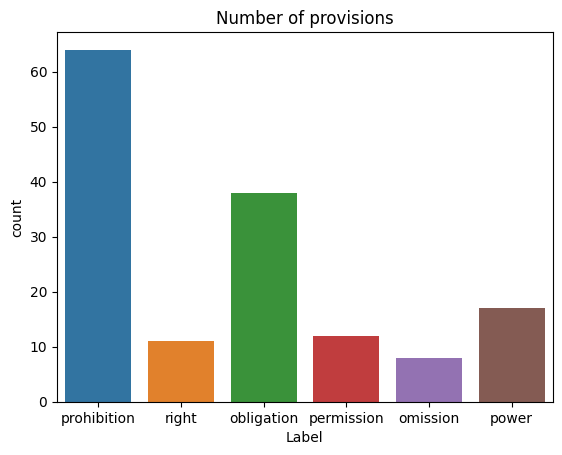

In [ ]:
sns.countplot(x=train_filtered_150["category"])
plt.xlabel('Label')
plt.title('Number of provisions')

Text(0.5, 1.0, 'Number of provisions')

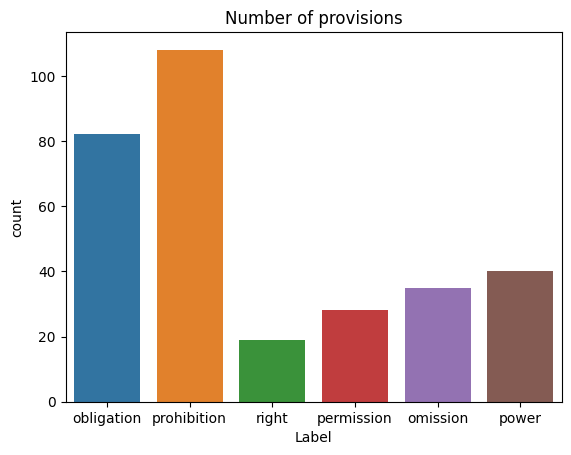

In [ ]:
sns.countplot(x=train_filtered_312["category"])
plt.xlabel('Label')
plt.title('Number of provisions')

Text(0.5, 1.0, 'Number of provisions')

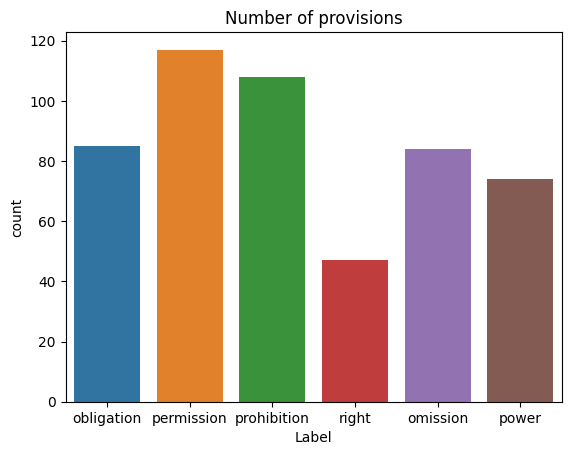

In [ ]:
sns.countplot(x=train_data["category"])
plt.xlabel('Label')
plt.title('Number of provisions')

In [ ]:
train_filtered_150.to_csv('/content/drive/MyDrive/train_filtered_150.csv', index=False)
train_filtered_312.to_csv('/content/drive/MyDrive/train_filtered_312.csv', index=False)

# Data Augmentation

In [ ]:
filtered_150 = pd.read_csv('/content/drive/MyDrive/train_filtered_150.csv', delimiter= ',')
filtered_312 = pd.read_csv('/content/drive/MyDrive/train_filtered_312.csv', delimiter= ',')
filtered_150

,text,category
0,It shall be prohibited to sell or use any prod...,prohibition
1,A person has the right to privacy.,right
2,Individuals must register for military service,obligation
3,Individuals are permitted to travel freely wit...,permission
4,Individuals must obtain a license to practice ...,obligation
...,...,...
145,Businesses must comply with intellectual prope...,obligation
146,It is prohibited to use someone else's credit ...,prohibition
147,It is not allowed to make false statements on ...,prohibition
148,Individuals must obtain a license to practice ...,obligation


In [ ]:
filtered_312

,text,category
0,Employers must pay their employees a living wage,obligation
1,It shall be prohibited to sell or use any prod...,prohibition
2,A person has the right to privacy.,right
3,Individual s must pay their taxes on time,obligation
4,Businesses must comply with health and safety ...,obligation
...,...,...
307,The legislature has the power to override a veto.,power
308,EU citizens are allowed to receive housing ass...,permission
309,Individuals have the liberty to challenge the ...,right
310,Individuals have the option to not provide per...,permission


In [ ]:
!pip install sentencepiece
from transformers import MarianMTModel, MarianTokenizer

In [ ]:

def backtranslation(df, original_language = 'en', temp_language="fr"):

    # English to Frensch tokenizer and pretrained model
    first_tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-en-fr')
    first_model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-en-fr')

    # French to English tokenizer and pretrained model
    second_tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-fr-en')
    second_model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-fr-en')

    # Prepare the text data into appropriate format for the model
    formated_batch = [">>{}<< {}".format(temp_language, text) for text in df['text']]

    # Generate translation using model
    translated = first_model.generate(**first_tokenizer(formated_batch, return_tensors="pt", padding=True))

    # Convert the generated tokens indices back into text
    translated_texts = [first_tokenizer.decode(t, skip_special_tokens=True) for t in translated]


    # Prepare the text data into appropriate format for the model
    temp_formated_batch = [">>{}<< {}".format(original_language, text) for text in translated_texts]

    # Generate translation using model
    backtranslated = second_model.generate(**second_tokenizer(formated_batch, return_tensors="pt", padding=True))

    # Convert the generated tokens indices back into text
    backtranslated_texts = [second_tokenizer.decode(t, skip_special_tokens=True) for t in backtranslated]

    for index, text in enumerate(df['text']):
      # Add a second sentence to the text entry
      df.at[index, 'text'] = text + '. ' + backtranslated_texts[index]+'.'


    return df


aug_train150 = backtranslation(filtered_150)
aug_train312 = backtranslation(filtered_312)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
nltk.download('punkt')

aug_train150["text"] = aug_train150["text"].apply(lambda x: sent_tokenize(x))
aug_train150 = aug_train150.explode('text')
aug_train150 = aug_train150.drop_duplicates()
aug_train150

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,text,category
0,It shall be prohibited to sell or use any prod...,prohibition
0,It will be prohibited to sell or use any produ...,prohibition
1,A person has the right to privacy.. A person h...,right
2,Individuals must register for military service.,obligation
3,Individuals are permitted to travel freely wit...,permission
...,...,...
146,It is prohibited to use someone else's credit ...,prohibition
147,It is not allowed to make false statements on ...,prohibition
148,Individuals must obtain a license to practice ...,obligation
148,· Individuals must obtain a license to practic...,obligation


In [ ]:
aug_train312["text"] = aug_train312["text"].apply(lambda x: sent_tokenize(x))
aug_train312 = aug_train312.explode('text')
aug_train312 = aug_train312.drop_duplicates()
aug_train312 = aug_train312.sample(frac=1).reset_index(drop=True)
aug_train312.reset_index(drop=True, inplace=True)
aug_train312

,text,category
0,It is prohibited to engage in bribery or other...,prohibition
1,The short has the power to issue subpoenas..,power
2,Individuals must obtain a license to practice ...,obligation
3,A person has the right to privacy.. A person h...,right
4,The executive branch has the power to appoint ...,power
...,...,...
422,A defendant is not required to take the stand ...,omission
423,A person has the right to a fair trial.. A per...,right
424,It is illegal to engage in sexual exploitation.,prohibition
425,A defendant is not obligated to take the stand...,omission


In [ ]:
aug_train312 = aug_train312.sample(frac=1).reset_index(drop=True)
aug_train150 = aug_train150.sample(frac=1).reset_index(drop=True)

In [ ]:
aug_train312['text'][426]

'A person has the right to freedom of speech.. A person has the right to freedom of speech..'

In [ ]:
aug_train312

,text,category
0,It is forbidden to engage in hat speech.,prohibition
1,It is not allowed to engage in political corru...,prohibition
2,Individuals have the freedom to challenge the ...,right
3,A person is not obligated to testify in a crim...,omission
4,A person is not compelled to answer questions ...,omission
...,...,...
422,It shall be prohibited to sell or use any prod...,prohibition
423,Businesses must comply with applicable environ...,obligation
424,People have the power to challenge the accurac...,right
425,It is not allowed to make false statements on ...,prohibition


In [ ]:
def cleaning(text):

  text = text.replace('• ', '')
  text = text.replace('..', '.')
  text = re.sub(r'\n\n', '. ', text)

  text = text.strip()

  return text

aug_train312['text'] = aug_train312['text'].apply(lambda x: cleaning(x))
aug_train150['text'] = aug_train150['text'].apply(lambda x: cleaning(x))

In [ ]:
aug_train312

,text,category
0,It is forbidden to engage in hat speech.,prohibition
1,It is not allowed to engage in political corru...,prohibition
2,Individuals have the freedom to challenge the ...,right
3,A person is not obligated to testify in a crim...,omission
4,A person is not compelled to answer questions ...,omission
...,...,...
422,It shall be prohibited to sell or use any prod...,prohibition
423,Businesses must comply with applicable environ...,obligation
424,People have the power to challenge the accurac...,right
425,It is not allowed to make false statements on ...,prohibition


In [ ]:
aug_train312.to_csv('/content/drive/MyDrive/aug_train312.csv', index=False)
aug_train150.to_csv('/content/drive/MyDrive/aug_train150.csv', index=False)

In [ ]:
aug_train150['category'].value_counts()

prohibition    88
obligation     55
power          28
right          15
permission     14
omission        9
Name: category, dtype: int64